In [1]:
import matplotlib.pyplot as plt

import finesse
from finesse.utilities.xaxis import xaxis, x2axis, noxaxis # convenience functions for running simulations over data ranges

finesse.plotting.init() # initialise matplotlib rcParams to appropriate values for a "display" mode
finesse.LOGGER.setLevel("WARN")

## Finesse 3 Introduction --- Fabry-Perot Cavity

This notebook is intended as an introduction to the Finesse 3 syntax and features by way of a simple example of a Fabry-Perot cavity configuration.

**Key Points**

- `.kat` files with largely the same syntax as Finesse 2 can be parsed into a Finesse 3 [Model](https://finesse.readthedocs.io/en/latest/api/finesse.model.html#module-finesse.model).
- This model object stores the [network](https://finesse.readthedocs.io/en/latest/api/generated/finesse.model.Model.network.html#finesse.model.Model.network) which is a directed graph
  where the `node_type` is the [full_name](https://finesse.readthedocs.io/en/latest/api/components/node/generated/finesse.components.node.Node.full_name.html#finesse.components.node.Node.full_name) property
  of a Node object. See [this documentation](https://finesse.readthedocs.io/en/latest/usage/advanced_usage/nodesystem/index.html) for in-depth details on the port and node system of Finesse 3.
- Parameter references can be set up in `.kat` files by using the `$` syntax:
  - track the parameter of another component using `$<comp_name>.param` -- e.g: `ad ampdet $EOM.f n1` tells Finesse to
    create an amplitude detector where the detection frequency is set up to track the frequency of the modulator named `EOM`.
  - more complicated referencing / tracking can be performed using `$$<eqn>$$` -- e.g. `ad ampdef $$EOM1.f + 2*EOM2.f$$ n1` tells Finesse
    to create an amplitude detector where the detection frequency is set to track a frequency equal to EOM1 modulation freq. plus two times EOM2 modulation freq.
- Simulations can be run over ranges of parameters with the `xaxis`, `x2axis` functions. Building of the Simulation object is performed internally within
  these functions using the model associated with the tunable parameters.

In the following cell we set up a Finesse model of a cavity using the familiar `.kat` style syntax. The amplitude detectors `Cp1` and `Cm1` are initialised such that the frequencies of the field that they detect track the positive and negative values of the modulator `eo1`, respectively. This means that if `eo1.f` is modified in any way later on, then `Cp1` and `Cm1` will still detect the upper and lower sidebands of the carrier circulating in the cavity. 

*Note: When we have different solvers (e.g. network reduction based solver) there may be an optional argument `solver="name_of_solver"` in xaxis, x2axis etc. which allows the user to choose which routine they want to use - defaulting to the current KLUMatrix solver acting on the whole coupling matrix.*

In [2]:
ifo = finesse.parse("""
l L0 1 0 n0

s s1 0 n0 nEOM1 
mod EOM1 100M .1 1 pm nEOM1 nEOM2
s s2 1 nEOM2 nITM1

m ITM 0.99 0.01 0 nITM1 nITM2
s sCAV 1 nITM2 nETM1
m ETM 0.99 0.01 0 nETM1 nETM2

# amplitude detector for reflected field at carrier frequency
ad R 0 nITM1
# amplitude detector for circulating field at carrier frequency
ad C 0 nETM1
# amplitude detector for circulating field at frequency = tracking mod freq. of eo1 (upper sideband)
ad Cp1 $EOM1.f nETM1
# amplitude detector for circulating field at frequency = -1 * tracking mod freq. of eo1 (lower sideband)
ad Cm1 $-1*EOM1.f nETM1
# amplitude detector for transmitted field at carrier frequency
ad T 0 nETM2
""")

# run a simulation where we vary the tuning of m1 from -100 deg to 280 deg with 1000 steps
out = xaxis(ifo.ITM.phi, -100, 280, 1000)

Upon running the simulation, we obtain an object `out` which acts as a wrapper around a `numpy` structured array whose named elements are the names of outputs in a model. So we can access, e.g., the output of the detector `Cp1` with `out['Cp1']`; whilst `out.x1` gives the data of the axis over which the first parameter was varied.

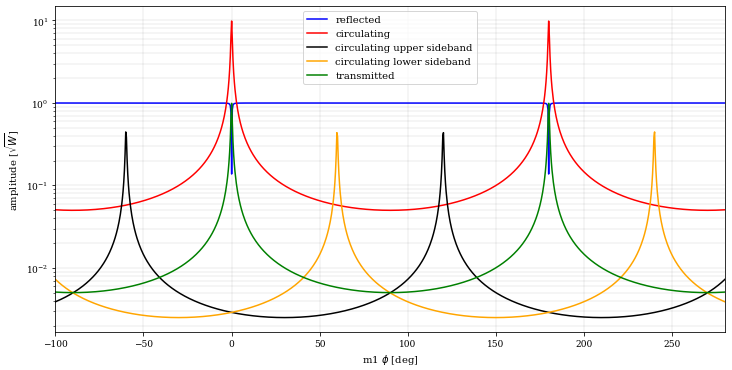

In [3]:
fig = plt.figure(figsize=(12, 6))
plt.semilogy(out.x1, abs(out['R']), label="reflected")
plt.semilogy(out.x1, abs(out['C']), label="circulating")
plt.semilogy(out.x1, abs(out['Cp1']), label="circulating upper sideband")
plt.semilogy(out.x1, abs(out['Cm1']), label="circulating lower sideband")
plt.semilogy(out.x1, abs(out['T']), label="transmitted")
plt.legend()
plt.xlabel("m1 $\phi$ [deg]")
plt.ylabel("amplitude [$\sqrt{W}$]");